## Creating a stimulus from an image

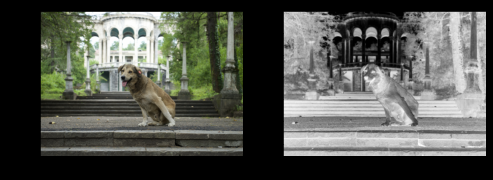

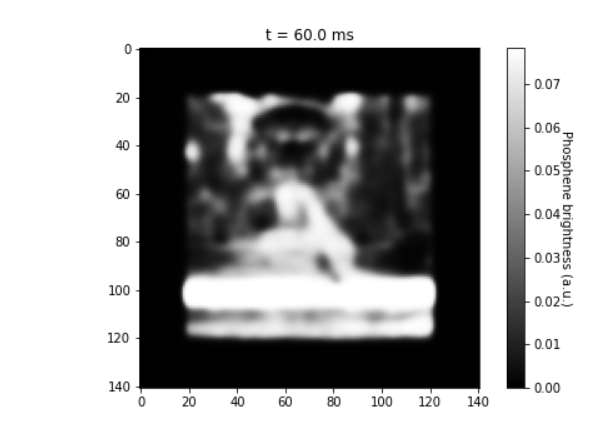
Input stimulus and predicted percept
(Top: input stimulus, right: predicted percept)

Using pulse2percept,built on the NumPy and SciPy stacks, pulse2percept provides an open-source implementation of a number of computational models for state-of-the-art visual prostheses (also known as the ‘bionic eye’), such as ArgusII, BVA24, and PRIMA, to provide insight into the visual experience provided by these devices.

By using this we can provide regulatory bodies with guidance into what sort of visual tests are appropriate for evaluating prosthetic performance, and improving current and future technology.

An image can be loaded as follows:
stim = ImageStimulus('path-to-image.png')

In [24]:
%matplotlib inline
import pulse2percept as p2p
import numpy as np

image_path = "C:\\Users\\cecil\\OneDrive\\Desktop\\Moodle\\FDD\\pr01-template-python-jupyter\\Images\\dog.jpg"
dog=p2p.stimuli.ImageStimulus(image_path)
print(dog)

ImageStimulus(data=<(1309440, 1) np.ndarray>, dt=0.001, 
              electrodes=<(1309440,) np.ndarray>, 
              img_shape=(682, 640, 3), 
              is_charge_balanced=False, metadata=dict, 
              shape=(1309440, 1), time=None)


Preprocessing an image:
To get the image into proper shape, we need to convert the 4-channel RGBA image to grayscal. In addition, 
since grayscale values will be mapped to current ampltiudes, we may want to invert the image so that image 
edges appear bright on a dark background.
We can perform both actions in one line, and plot the result side-by-side with the original image:

<AxesSubplot:>

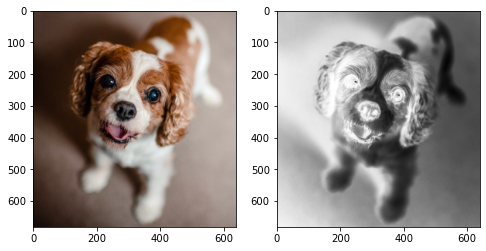

In [25]:
dog_gray = dog.invert().rgb2gray()

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
dog.plot(ax=ax1)
dog_gray.plot(ax=ax2)

## Using the image as input to a retinal implant

class:`ImageStimulus` can be used in
combination with any method`ProsthesisSystem`.
We just have to resize the image first so that the number of pixels in the
image matches the number of electrodes in the implant.

But let's start from the top. The first two steps are to create a model and
choose an implant:

<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

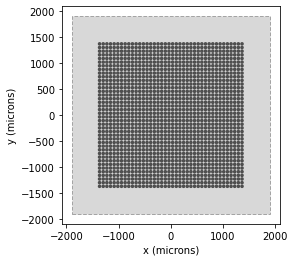

In [26]:
# Simulate only what we need (14x14 deg sampled at 0.1 deg):
model = p2p.models.ScoreboardModel(xrange=(-7, 7), yrange=(-7, 7), xystep=0.1)
model.build()

from pulse2percept.implants import AlphaAMS
implant = AlphaAMS()

# Show the visual field we're simulating (dashed lines) atop the implant:
model.plot()
implant.plot()

Since implants.AlphaAMS is a 2D electrode grid, all we need to do is downscale the image to the size of the grid:

In [27]:
implant.stim = dog_gray.resize(implant.shape)

This way, the pixels of the image will be assigned to the electrodes in row-by-row order

<AxesSubplot:xlabel='x (degrees of visual angle)', ylabel='y (degrees of visual angle)'>

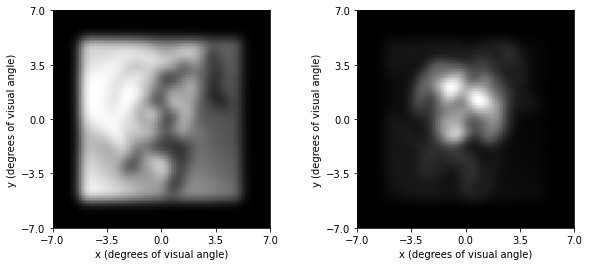

In [28]:
dog_edge = dog_gray.filter('scharr')
from skimage.morphology import dilation
dog_dilate = dog_edge.apply(dilation)

percept_gray = model.predict_percept(implant)
implant.stim = dog_dilate.trim().resize(implant.shape)
percept_dilate = model.predict_percept(implant)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
percept_gray.plot(ax=ax1)
percept_dilate.plot(ax=ax2)

## Converting the image to a series of electrical pulses

class: ImageStimulus has an encode method
to convert an image into a series of pulse trains (i.e., into electrical
stimuli with a time component).

By default, the ``encode`` method will interpret the gray level of a pixel as
the current amplitude of a class BiphasicPulse



In [29]:
implant.stim = dog_dilate.trim().resize(implant.shape).encode()

## Using the image as input to a spatiotemporal model

Now, if we passed the new stimulus to
class:`ScoreboardModel`, it would simply apply the
model (in space) to every time point in the stimulus.
To get a proper temporal response, we need to extend the scoreboard model
with a proper temporal model, such as class:`Nanduri2012Temporal`

In [30]:
model = p2p.models.Model(spatial=p2p.models.ScoreboardModel,
                         temporal=p2p.models.Nanduri2012Temporal)

To make the model focus on the same visual field as above, we set ``xrange``,
``yrange``, and choose a proper ``xystep``.

The ``rho`` parameter of the scoreboard model controls how much blur we get
in the resulting percept. The value of this parameter should be set
empirically to match the quality of the vision reported behaviorally by each
implant user.
For the purpose of this tutorial, we will set it to 50um:

In [31]:
model.build(xrange=(-7, 7), yrange=(-7, 7), xystep=0.1, rho=50)

Model(asymptote=14.0, dt=0.005, engine=None, eps=8.73, 
      grid_type='rectangular', n_gray=None, n_jobs=1, 
      n_threads=8, noise=None, retinotopy=Watson2014Map, 
      rho=50, scale_out=1.0, scheduler='threading', 
      shift=16.0, slope=3.0, spatial=ScoreboardSpatial, 
      tau1=0.42, tau2=45.25, tau3=26.25, 
      temporal=Nanduri2012Temporal, thresh_percept=0, 
      verbose=True, xrange=(-7, 7), xystep=0.1, 
      yrange=(-7, 7))

The predicted percept will now be a movie, where the spatial response (i.e., each frame of the movie) is primarily determined by the scoreboard model, but the temporal evolution of these frames is determined by the Nanduri model.

In [32]:
percept = model.predict_percept(implant)
#!pip install imageio-ffmpeg
percept.play()


In [ ]:
percept.save('dog_percept.mp4')